# XGBoost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

## Types of Time Series Data

![Types of Time Series Data](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

In [2]:
# import csv dataset
df=pd.read_csv('divvy-tripdata_cleaned.csv',index_col=1,parse_dates=True)

# make into dataframe
df2=pd.DataFrame(df)

# which columns to include alongside column acting as index
cols=[3]
df2=df2[df2.columns[cols]]

In [3]:
# sorting the dataframe
df3=df2.sort_values("start_time")
df3.head()

,trip_duration
start_time,
2013-06-30 10:48:00,557
2013-06-30 10:51:00,12496
2013-06-30 11:27:00,699
2013-06-30 11:35:00,1093
2013-06-30 11:56:00,3957


<AxesSubplot:title={'center':'Trip Duration'}, xlabel='start_time'>

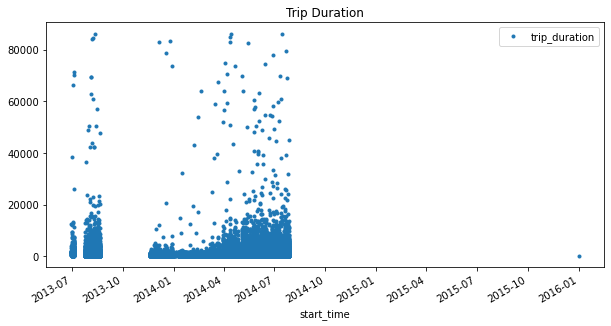

In [4]:
# plotting the data
df3.plot(style='.',figsize=(10,5), title='Trip Duration')

## Train / Test Split

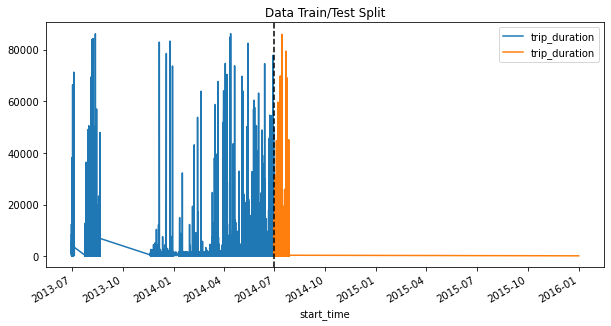

In [5]:
train=df3.loc[df3.index<'2014-06-30 10:51:00']
test=df3.loc[df3.index>='2014-06-30 10:51:00']

fig,ax=plt.subplots(figsize=(10,5))
train.plot(ax=ax,label='Training Set',title='Data Train/Test Split')
test.plot(ax=ax,label='Test Set')
ax.axvline('2014-06-30 10:51:00',color='black',ls='--')
plt.show()

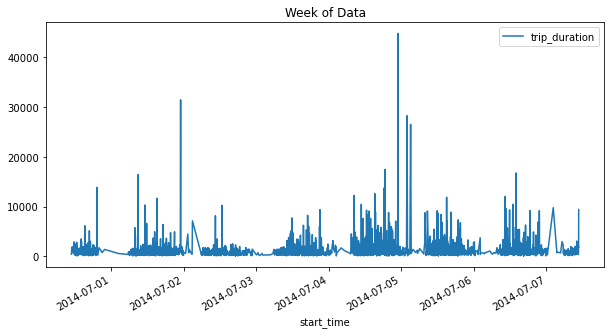

In [6]:
df3.loc[(df3.index>'2014-06-30 10:51:00') & (df3.index<'2014-07-07 10:51:00')].plot(figsize=(10,5),title='Week of Data')
plt.show()

## Feature Creation

In [7]:
def create_features(df3):
    """
    Create time series features based on time series index.
    """
    df3 = df3.copy()
    df3['hour'] = df3.index.hour
    df3['dayofweek'] = df3.index.dayofweek
    df3['quarter'] = df3.index.quarter
    df3['month'] = df3.index.month
    df3['year'] = df3.index.year
    df3['dayofyear'] = df3.index.dayofyear
    df3['dayofmonth'] = df3.index.day
    df3['weekofyear'] = df3.index.isocalendar().week
    return df3

df3 = create_features(df3)

## Visualize our Feature / Target Relationship

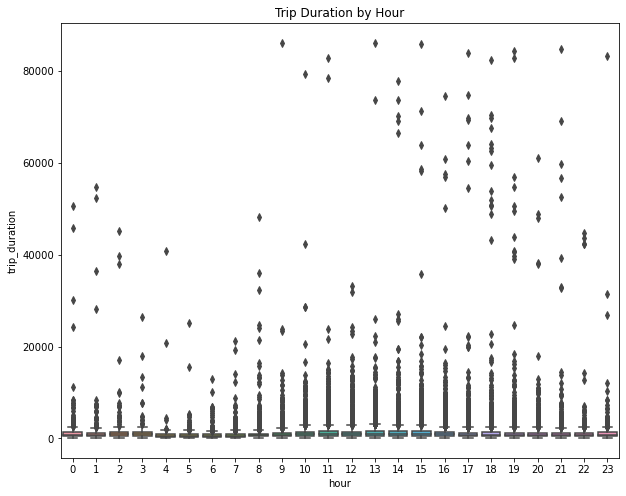

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df3, x='hour', y='trip_duration')
ax.set_title('Trip Duration by Hour')
plt.show()

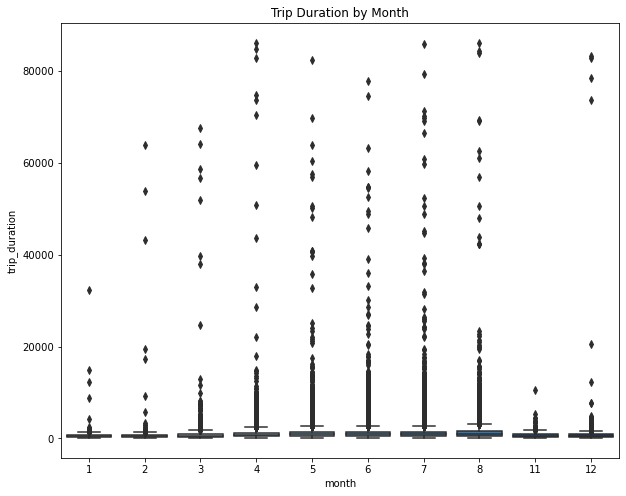

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df3, x='month', y='trip_duration', palette='Blues')
ax.set_title('Trip Duration by Month')
plt.show()

## Create our Model

In [10]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'trip_duration'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [11]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[11:51:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2685.11267	validation_1-rmse:2239.26001
[100]	validation_0-rmse:2464.27478	validation_1-rmse:1938.58697
[200]	validation_0-rmse:2429.34886	validation_1-rmse:1922.01194
[209]	validation_0-rmse:2428.27544	validation_1-rmse:1923.31879


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

## Feature Importance

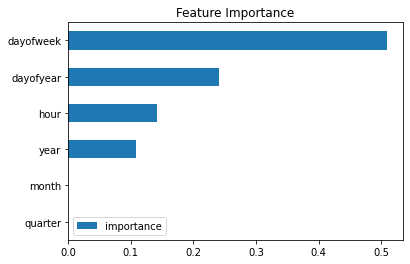

In [12]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test

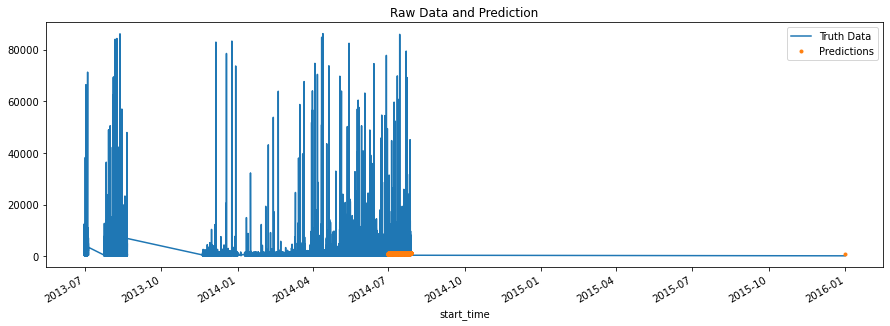

In [13]:
test['prediction'] = reg.predict(X_test)
df3 = df3.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df3[['trip_duration']].plot(figsize=(15, 5))
df3['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

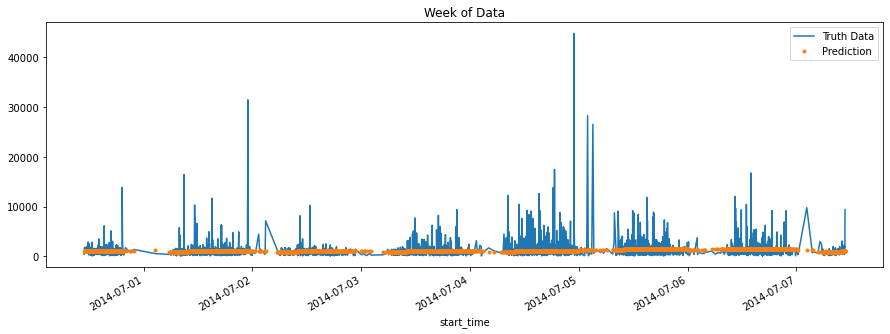

In [14]:
ax = df3.loc[(df3.index > '2014-06-30 10:51:00') & (df3.index < '2014-07-07 10:51:00')]['trip_duration'] \
    .plot(figsize=(15, 5), title='Week of Data')
df3.loc[(df3.index > '2014-06-30 10:51:00') & (df3.index < '2014-07-07 10:51:00')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

## Score (RMSE)

In [15]:
score = np.sqrt(mean_squared_error(test['trip_duration'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1919.58


## Calculate Error

In [16]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2014-07-04    938.765429
2014-07-13    891.632994
2014-07-26    855.247407
2014-07-12    848.162440
2014-07-05    847.265158
2014-07-27    798.826949
2014-07-19    782.965365
2014-07-06    769.987332
2014-07-20    755.432938
2014-07-07    731.115625
Name: error, dtype: float64